## Filter out guides that are multi-targeting

Run this script after: `align_guides.R`

**Input:**  
- Guide alignment file computed in `align_guides.R`
- Guide level log-fold changes file downloaded from DepMap
- List of dropped guides from DepMap portal
- HGNC gene ID map

**Output:**  
- Filtered version of the log-fold changes file

Notes: 
- From 19Q3 DepMap does alignment to GRCh38, this is mentioned in Tsherniak et al (2019) https://www.biorxiv.org/content/10.1101/720243v1.full
- Guides that have > 100 alignments are not used by CERES.  
- Definitions of "PAM-distal" are taken from Fortin et al (2019): https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1621-7

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import re
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({'font.size': 10, 'axes.spines.top': False, 'axes.spines.right': False})

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

# Input from DepMap
file_logfold_changes = lambda v: get_data_path(['depmap', v], ('Achilles_' if v=='20Q2' else '')+'logfold_change.csv')
file_guide_map = lambda v: get_data_path(['depmap', v], 'Achilles_guide_map.csv' if v=='20Q2' else 'guide_gene_map.csv')
file_dropped_guides = get_data_path(['depmap', '20Q2'], 'Achilles_dropped_guides.csv') # only for Broad

# Input from R script
file_alignments = lambda v: get_local_data_path(['processed', v], 'guide_alignments_hg38.csv')

# Input from 1_data_processing
file_id_map = get_local_data_path(['processed'], 'HGNC_gene_id_map.csv')

# OUTPUT
file_filtered_lfc = lambda v, d: get_local_data_path(['processed', v], 'filtered_lfc_'+d+'.csv')
file_guides_per_gene = lambda v, d: get_local_data_path(['processed', v], 'guides_per_gene_'+d+'.csv')

### Load guide-gene map from DepMap for comparisson

In [2]:
# For comparison - note this would only include perfect alignments
# From DepMap portal: n_alignments (integer number of perfect matches for that guide)
def load_depmap_guide_map(fname):
    depmap_guide_map = pd.read_csv(fname).dropna()
    assert(depmap_guide_map[depmap_guide_map.gene.isna()].shape[0]==0)

    # Extract Entrez ID and symbol
    get_gene_id = lambda x: int(re.search('[\w-]+\s\((\w+)\)', x).group(1))
    get_gene_symbol = lambda x: re.search('([\w-]+)\s\(\w+\)', x).group(1)
    depmap_guide_map['symbol'] = depmap_guide_map.gene.apply(get_gene_symbol)
    depmap_guide_map['entrez_id'] = depmap_guide_map.gene.apply(get_gene_id)

    # Exclude X/Y chr genes - I didn't align to those
    depmap_guide_map = depmap_guide_map[~depmap_guide_map.genome_alignment.str.startswith('chrX') & 
                                        ~depmap_guide_map.genome_alignment.str.startswith('chrY')]

    # Add locus type info
    id_map = pd.read_csv(file_id_map, index_col=0)[['locus_type','entrez_id']]
    id_map = id_map.dropna(subset=['entrez_id']).astype({'entrez_id':'int'})
    depmap_guide_map = pd.merge(depmap_guide_map, id_map, how='left')

    print('# of guides:', depmap_guide_map.sgrna.nunique())
    return depmap_guide_map

In [3]:
depmap_guide_map = load_depmap_guide_map(file_guide_map('20Q2'))
display(depmap_guide_map[:1])

# of guides: 69259


,sgrna,genome_alignment,gene,n_alignments,symbol,entrez_id,locus_type
0,AAAAAAATCCAGCAATGCAG,chr10_110964620_+,SHOC2 (8036),1,SHOC2,8036,gene with protein product


In [4]:
sanger_guide_map = load_depmap_guide_map(file_guide_map('sanger'))
display(sanger_guide_map[:1])

# of guides: 84039


,sgrna,genome_alignment,gene,symbol,entrez_id,locus_type
0,TGCTGACGGGTGACACCCA,chr19_58353007_-,A1BG (1),A1BG,1,gene with protein product


### Load alignments computed in R script + compute alignment type

In [5]:
# Calculate alignment type based on the 'alignment' encoding 
# PAM-distal = in the 10 nucleotides furthest from the PAM for single mismatch
# PAM-distal = in the 2 nucleotides furthest from the PAM for double mismatch
def get_alignment_type(row, perfect_alignment):
    if row.alignment == str(perfect_alignment):
        return 'perfect'
    match = re.search('^(\d+)[ATCG]\d+$', row.alignment)
    if match != None:
        if ((row.strand == '+' and int(match.group(1)) <= 9) or 
            (row.strand == '-' and int(match.group(1)) >= (perfect_alignment-9))):
            return 'pam_distal_single'
        return 'single'
    match = re.search('^(\d+)[ATCG](\d+)[ATCG](\d+)$', row.alignment)
    if match != None:
        if ((row.strand == '+' and int(match.group(3)) == (perfect_alignment-2)) or 
            (row.strand == '-' and int(match.group(1)) == (perfect_alignment-2))):
            return 'pam_distal_double'
        return 'double'

def load_alignments(fname, perfect_alignment):
    # Load and clean the alignment file generated in R notebook
    raw_alignments = pd.read_csv(fname)
    display(raw_alignments[:1])
    
    # Duplicates: different CDS_start and CDS_end (multiple exons) - but only considering gene level
    alignments = raw_alignments.drop_duplicates(subset=['sgrna', 'gene', 'geneID', 'alignment'])
    alignments = alignments.rename(columns={'geneID':'entrez_id'})
    alignments = alignments[['sgrna', 'alignment', 'entrez_id', 'gene', 'chr', 'strand', 'cut_pos']].sort_values('gene')
    print('# of guides:', alignments.sgrna.nunique())

    # Expect no alignment to X/Y chromosomes
    assert(alignments[(alignments.chr == 'chrX') | (alignments.chr == 'chrY')].shape[0] == 0)
    
    # Arg perfect_alignment is length of guides: Broad=20, Sanger=19
    alignments = alignments.assign(align_type = alignments.apply(get_alignment_type, args=[perfect_alignment], axis=1))
    
    return alignments

In [6]:
all_alignments = load_alignments(file_alignments('depmap20Q2'), perfect_alignment=20)
display(all_alignments[:1])

,sgrna,chr,cut_pos,strand,alignment,gene,geneID,CDS_strand,CDS_start,CDS_end
0,AAAAAAATCCAGCAATGCAG,chr10,110964620,+,20,SHOC2,8036,+,110964358,110965060


# of guides: 70509


,sgrna,alignment,entrez_id,gene,chr,strand,cut_pos,align_type
83854,GTGTGCCGAGGTGTGCTGCG,20,1,A1BG,chr19,-,58352467,perfect


In [7]:
all_alignments_sanger = load_alignments(file_alignments('sanger'), perfect_alignment=19)
display(all_alignments_sanger[:1])

,sgrna,chr,cut_pos,strand,alignment,gene,geneID,CDS_strand,CDS_start,CDS_end
0,TGCTGACGGGTGACACCCA,chr19,58353007,-,19,A1BG,1,-,58352927,58353196


# of guides: 84621


,sgrna,alignment,entrez_id,gene,chr,strand,cut_pos,align_type
0,TGCTGACGGGTGACACCCA,19,1,A1BG,chr19,-,58353007,perfect


### Filter guide-gene map
1. Drop guides dropped by DepMap
2. Drop guides that target readthrough genes
3. Identify and drop multi-targeting guides

In [8]:
def filter_dropped_depmap_guides(fname, alignments, ax):
    depmap_dropped_guides = pd.read_csv(fname).rename(columns={'Unnamed: 0':'sgrna'})
    print('# of guides dropped by DepMap:', depmap_dropped_guides.sgrna.nunique(), '- # to drop here:', 
          alignments[alignments.sgrna.isin(depmap_dropped_guides.sgrna)].sgrna.nunique())

    # Reasons for dropped guides, 'in_dropped_guides' => suspected off-target activity
    df = depmap_dropped_guides[depmap_dropped_guides.sgrna.isin(alignments.sgrna)]
    df = df.assign(fail_reason = df.fail_reason.apply(lambda x: 'off-target activity' if x=='in_dropped_guides' else x))
    sns.countplot(data=df, y='fail_reason', ax=ax, color='#0072b2', order=df['fail_reason'].value_counts().index)
    ax.set_title('DepMap guide fail reasons', fontsize=11); ax.set_ylabel('')

    # Drop guides that were dropped in Depmap analysis
    new_alignments = alignments[~alignments.sgrna.isin(depmap_dropped_guides.sgrna)].rename(columns={'gene':'symbol'})
    
    # Also don't count guides that map via non-PAM-distal double mismatch
    new_alignments = new_alignments[(new_alignments.align_type != 'double')].reset_index(drop=True)
    
    print('# of guides left:', new_alignments.sgrna.nunique())
    
    # Check that sgRNAs are the same in this map and depmap guide map
    assert(new_alignments[(new_alignments.align_type=='perfect') & 
                          ~new_alignments.sgrna.isin(depmap_guide_map.sgrna)].shape[0]==0)
    assert(depmap_guide_map[~depmap_guide_map.sgrna.isin(new_alignments.sgrna)].shape[0]==0)
    return new_alignments

In [9]:
def filter_guides_targeting_readthroughs(alignments, ax):
    # Add locus info, e.g. read-through gene
    id_map = pd.read_csv(file_id_map, index_col=0)[['locus_type','entrez_id']]
    id_map = id_map.dropna(subset=['entrez_id']).astype({'entrez_id':'int'})
    alns = pd.merge(alignments, id_map, how='left')

    # Manual curation - extra genes to mark as read-through
    genes_to_mark_as_readthrough = ['LOC110117498-PIK3R3']
    alns.loc[alns.symbol.isin(genes_to_mark_as_readthrough), 'locus_type'] = 'readthrough'

    # Plot genes that are not classified as "gene with protein product"
    df = alns[alns.locus_type!='gene with protein product']
    _=sns.countplot(data=df, y='locus_type', ax=ax, color='#0072b2', order=df['locus_type'].value_counts().index)
    ax.set_title('Non-protein-coding genes in alignments', fontsize=11); ax.set_ylabel('')

    # Drop all guides targeting readthrough genes
    readthrough_guides = alns[alns.locus_type=='readthrough'].sgrna.unique()
    print('# of guides aligned to 1+ readthrough genes:', len(readthrough_guides))
    new_alignments = alns[~alns.sgrna.isin(readthrough_guides)].reset_index(drop=True)
    assert(new_alignments[new_alignments.locus_type=='readthrough'].shape[0]==0)
    print('# of guides left:', new_alignments.sgrna.nunique())
    
    return new_alignments

In [10]:
def filter_multi_targeting_guides(alignments, all_alignments):
    # Drop alignments to non-protein-coding genes - don't want to consider these when counting num alignments
    # Also won't use scores for non-protein coding genes post-ceres
    guide_map = alignments[alignments.locus_type=='gene with protein product'].reset_index(drop=True)
    guide_map = guide_map.drop(columns=['locus_type'])

    # Annotate guides with number of genes they align to
    # Only count 1 alignment per sgrna-gene pairs - guide could match to gene at multiple loci
    num_alns = guide_map.groupby('sgrna').entrez_id.nunique().reset_index().rename(columns={'entrez_id':'n_aln'})
    guide_map = pd.merge(guide_map, num_alns)
    #display(guide_map[:1])
    
    # Filter out guides that align to more than one coding gene
    guides_w_multiple_alns = guide_map[guide_map.n_aln > 1]
    print('# of multi-targeting guides:', guides_w_multiple_alns[guides_w_multiple_alns.align_type=='perfect'].sgrna.nunique())
    unique_alignments = guide_map[~guide_map.sgrna.isin(guides_w_multiple_alns.sgrna)].reset_index(drop=True)

    dropped_guides = all_alignments[~all_alignments.sgrna.isin(unique_alignments.sgrna)].sgrna.unique()
    print('Total # of dropped guides:', len(dropped_guides))

    # For final alignment map only consider perfect alignments
    unique_alignments = unique_alignments[unique_alignments.align_type=='perfect'].reset_index(drop=True)

    return unique_alignments, dropped_guides

#### Broad

# of guides dropped by DepMap: 2554 - # to drop here: 1006
# of guides left: 69305


,sgrna,alignment,entrez_id,symbol,chr,strand,cut_pos,align_type
0,GTGTGCCGAGGTGTGCTGCG,20,1,A1BG,chr19,-,58352467,perfect


# of guides aligned to 1+ readthrough genes: 365
# of guides left: 68940


,sgrna,alignment,entrez_id,symbol,chr,strand,cut_pos,align_type,locus_type
0,GTGTGCCGAGGTGTGCTGCG,20,1,A1BG,chr19,-,58352467,perfect,gene with protein product


# of multi-targeting guides: 3252
Total # of dropped guides: 5197


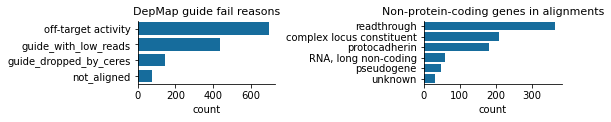

In [12]:
f, ax = plt.subplots(1, 2, figsize=(8,1.8))
alignments_1 = filter_dropped_depmap_guides(file_dropped_guides, all_alignments, ax[0])
display(alignments_1[:1])

alignments_2 = filter_guides_targeting_readthroughs(alignments_1, ax[1])
display(alignments_2[:1])

unique_alignments, dropped_guides = filter_multi_targeting_guides(alignments_2, all_alignments)
plt.tight_layout()

#### Sanger

,sgrna,alignment,entrez_id,symbol,chr,strand,cut_pos,align_type
0,TGCTGACGGGTGACACCCA,19,1,A1BG,chr19,-,58353007,perfect


# of guides aligned to 1+ readthrough genes: 525
# of guides left: 83917


,sgrna,alignment,entrez_id,symbol,chr,strand,cut_pos,align_type,locus_type
0,TGCTGACGGGTGACACCCA,19,1,A1BG,chr19,-,58353007,perfect,gene with protein product


# of multi-targeting guides: 1556
Total # of dropped guides: 2692


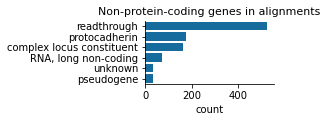

In [14]:
f, ax = plt.subplots(1, 1, figsize=(4,1.8))
# Sanger data doesn't have dropped guides file associated with it
alignments_sanger_1 = all_alignments_sanger[(all_alignments_sanger.align_type != 'double')].rename(columns={'gene':'symbol'})
display(alignments_sanger_1[:1])

alignments_sanger_2 = filter_guides_targeting_readthroughs(alignments_sanger_1, ax)
display(alignments_sanger_2[:1])

unique_alignments_sanger, dropped_guides_sanger = filter_multi_targeting_guides(alignments_sanger_2, all_alignments_sanger)
plt.tight_layout()

#### Some sanity checks on DepMap data

In [15]:
# Check that sgRNA mappings in depmap guide map are all in this map
df = pd.merge(depmap_guide_map[['sgrna','entrez_id','gene']], 
              alignments_1[['sgrna','entrez_id','symbol','align_type']], on=['sgrna','entrez_id'], how='outer')
print('Mappings missing from my map:', df[df.symbol.isna()].shape[0])

Mappings missing from my map: 0


In [23]:
# Check that sgRNA mappings in depmap guide map are all in this map
df = pd.merge(depmap_guide_map[['sgrna','entrez_id','gene']], 
              alignments_2[['sgrna','entrez_id','symbol','align_type']], on=['sgrna','entrez_id'], how='outer')
print('Mappings missing from depmap:', df[(df.align_type=='perfect')&(df.gene.isna())].shape[0])
print(df[(df.align_type=='perfect')&(df.gene.isna())].symbol.unique())

Mappings missing from depmap: 8
['PALM2-AKAP2']


### Count guides per gene after filtering

In [24]:
# Save out guides per gene to use in CERES post-processing
def save_guides_per_gene(unique_alignments, fname):
    assert(unique_alignments[unique_alignments.align_type!='perfect'].shape[0] == 0)
    guides_per_gene = unique_alignments.groupby(['symbol', 'entrez_id']).sgrna.nunique().reset_index()
    guides_per_gene = guides_per_gene.rename(columns={'sgrna':'guides_per_gene'})
    guides_per_gene.to_csv(fname)
    print('Map size (n genes):', guides_per_gene.shape[0])
    display(guides_per_gene[:2])

In [25]:
save_guides_per_gene(unique_alignments, file_guides_per_gene('depmap20Q2','16_04_21'))

Map size (n genes): 17048


,symbol,entrez_id,guides_per_gene
0,A1BG,1,4
1,A1CF,29974,4


In [26]:
save_guides_per_gene(unique_alignments_sanger, file_guides_per_gene('sanger','16_04_21'))

Map size (n genes): 16659


,symbol,entrez_id,guides_per_gene
0,A1BG,1,5
1,A1CF,29974,5


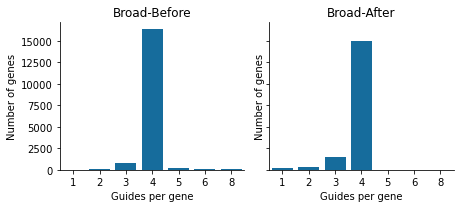

In [27]:
# Guides per gene before and after filtering
def plot_guides_per_gene(guide_map, ax):
    guides_per_gene = pd.DataFrame(guide_map.groupby('entrez_id').sgrna.nunique())
    guides_per_gene = guides_per_gene.assign(counts = guides_per_gene.sgrna.apply(lambda x: 10 if x>=10 else x))
    sns.countplot(x=guides_per_gene.counts, ax=ax, color='#0072b2')
    ax.set_xlabel('Guides per gene'); ax.set_ylabel('Number of genes')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5,3), sharey=True, sharex=True)
plot_guides_per_gene(alignments_2[alignments_2.align_type=='perfect'], ax1) # This is after first 2 filtering steps
plot_guides_per_gene(unique_alignments, ax2)
ax1.set_title('Broad-Before'); ax2.set_title('Broad-After'); plt.tight_layout()

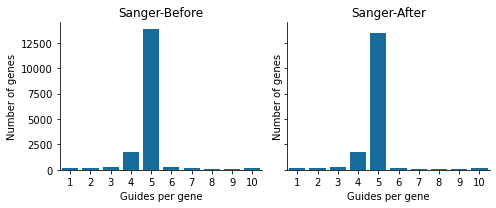

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3), sharey=True)
plot_guides_per_gene(alignments_sanger_2[alignments_sanger_2.align_type=='perfect'], ax1)
plot_guides_per_gene(unique_alignments_sanger, ax2)
ax1.set_title('Sanger-Before'); ax2.set_title('Sanger-After'); plt.tight_layout()

### Filter original log-fold change file
This is the post-QC LFC

#### Broad

In [29]:
orig_lfc = pd.read_csv(file_logfold_changes('20Q2'), index_col=0)

In [30]:
print("N orig LFC:", orig_lfc.shape[0])
orig_lfc[:1]

N orig LFC: 74687


,143B-311Cas9_RepA_p6_batch3,2313287-311Cas9_RepA_p5_batch3,2313287-311Cas9_RepB_p5_batch3,253J-311Cas9_RepA_p5_batch3,42-MG-BA-311Cas9_RepA_p6_batch3,42-MG-BA-311Cas9_RepB_p6_batch3,5637-311Cas9_RepA_p6_batch3,5637-311Cas9_RepB_p6_batch3,59M-311Cas9_RepA_p4_batch3,59M-311Cas9_RepB_p4_batch3,...,YD8-311Cas9_RepA_p6_batch3,YD8-311Cas9_RepB_p6_batch3,YH-13-311Cas9_RepA_p6_batch3,YH-13-311Cas9_RepB_p6_batch3,YKG1-311Cas9_RepA_p6_batch3,YKG1-311Cas9_RepB_p6_batch3,YSCCC-311cas9-RepA-p6_batch3,YSCCC-311cas9-RepB-p6_batch3,ZR-75-1-311Cas9_RepA_p5_batch2,ZR-75-1-311Cas9_RepB_p5_batch2
Construct Barcode,,,,,,,,,,,,,,,,,,,,,
AAAAAAATCCAGCAATGCAG,0.289694,0.171917,-0.522717,-0.21169,-1.067942,-0.432573,-0.57371,0.012167,0.371828,-0.460308,...,-0.932634,-0.42067,-0.483853,-0.00565,-0.080897,-0.144761,-0.215475,-0.161553,-0.963836,-0.256333


In [31]:
filtered_lfc = orig_lfc[~orig_lfc.index.isin(dropped_guides)]
print('Filtered lfc:', filtered_lfc.shape[0])

Filtered lfc: 69490


In [32]:
filtered_lfc.to_csv(file_filtered_lfc('depmap20Q2', '16_04_21'))

#### Sanger

In [33]:
orig_lfc_sanger = pd.read_csv(file_logfold_changes('sanger'), index_col=0)

In [34]:
print("N sgrna in orig Sanger LFC:", orig_lfc_sanger.shape[0])
orig_lfc_sanger[:1]

N sgrna in orig Sanger LFC: 89477


,A375_C902R1_P1D14,A375_C902R2_P1D14,A375_C902R3_P1D14,A375_c902R4,A375_c902R5,A375_c902R6,HCT15_C902R1_P1D14,HCT15_C902R2_P1D14,HCT15_C902R3_P1D14,HCT15_c902R4,...,U87MG_c907R1,U87MG_c907R2,YH13_c907R1,YH13_c907R2,42MGBA_c907R1,D423MG_c907R2,IM95_c908R3,MB468_c903R1,MDST8_c903R3,H1355_c906R1
TGCTGACGGGTGACACCCA,-0.4446,-0.276138,-0.057663,-0.541072,-0.071765,-0.695229,-0.085053,0.264002,0.259816,-0.242496,...,-0.225926,0.026574,-1.313162,-1.069462,0.488873,0.783022,-0.201151,-0.148249,-0.248523,0.189


In [173]:
filtered_lfc_sanger = orig_lfc_sanger[~orig_lfc_sanger.index.isin(dropped_guides_sanger)]
print('Sanger filtered lfc:', filtered_lfc_sanger.shape[0])

Sanger filtered lfc: 86785


In [35]:
filtered_lfc_sanger = orig_lfc_sanger[~orig_lfc_sanger.index.isin(dropped_guides_sanger)]
print('Sanger filtered lfc:', filtered_lfc_sanger.shape[0])

Sanger filtered lfc: 86785


In [36]:
filtered_lfc_sanger.to_csv(file_filtered_lfc('sanger','16_04_21'))